# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import time
notebook_tic = time.time()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# Set this to True if you want to save time and not do some of the analysis, plotting, fitting, and slow tasks
DEV_MODE = True

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
%%time
# Load in the general demographics data.
gen_original = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
gen = gen_original.copy()
# Load in the feature summary file.
feats = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

CPU times: user 7.1 s, sys: 1.8 s, total: 8.9 s
Wall time: 9.23 s


In [4]:
gen.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 85 entries, AGER_TYP to RELAT_AB
dtypes: float64(49), int64(32), object(4)
memory usage: 578.0+ MB


In [5]:
object_types = list(gen.select_dtypes(include=['object']).columns)
print('Columns of type object: {}'.format(object_types))
print('These may need label encoding')

Columns of type object: ['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']
These may need label encoding


In [6]:
gen.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
if not DEV_MODE:
    gen.describe()

In [8]:
feats.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.

In [10]:
def string_to_list(string):
    """convert string into a list of integers and strings"""
    list_of_strings = (string.replace('[', '').replace(']', '').split(','))
    for i in range(len(list_of_strings)):
        if list_of_strings[i] in ['-1', '0', '9']:
            list_of_strings[i] = int(list_of_strings[i])
    return list_of_strings

In [11]:
def convert_values_to_nan(df, features_df):
    """Convert values in Udacity_AZDIAS_Subset.csv that correspond to the list 
    'missing_or_unknown' in AZDIAS_Feature_Summary.csv
    """
    # Convert features_df['missing_or_unknown'] from a string to a list
    features_df['nulls'] = features_df['missing_or_unknown'].map(string_to_list)
    
    # Convert null values in df to np.nan
    for col in list(df.columns):
        list_of_nulls = list(features_df.loc[features_df.attribute==str(col)]['nulls'])[0]
        df.loc[df[col].isin(list_of_nulls),col] = np.nan
        
    return df

In [12]:
%%time
gen_nulls = gen_original.copy()
gen_nulls = convert_values_to_nan(gen_nulls, feats)

CPU times: user 14.9 s, sys: 25.4 s, total: 40.2 s
Wall time: 40.7 s


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def get_null_percentage(df):
    """
    Input: dataframe
    Output: series with percentage of null values for each column
    """
    null_perc = df.isnull().mean()*100
    null_perc = null_perc.sort_values(ascending=False)
    return null_perc

if not DEV_MODE:
    null_percentage = get_null_percentage(gen_nulls)

In [14]:
# Investigate patterns in the amount of missing data in each column.

Most of the columns have a percentage of null values below 20%.  Six columns have proportions greater than 20%, sometimes much greater.

In [15]:
if not DEV_MODE:
    plt.hist(null_percentage, bins = 20)
    plt.title('Distribution of percentage null')
    plt.ylabel('Number of Columns')
    plt.xlabel('Percentage of Column that is null')
    plt.show()

In [16]:
if not DEV_MODE:
    plt.figure(figsize=(16,5))
    null_percentage.plot.bar()
    plt.ylabel('Percentage Null')
    plt.xlabel('Column Name')
    plt.title('Percentage Null by column name')
    plt.show()

In [17]:
# List and describe columns with high percentage of null values
if not DEV_MODE:
    threshold = 20
    outlier_df = pd.DataFrame(null_percentage[null_percentage>threshold], columns=['percent_null'])
    outlier_df['description'] = ['Academic title flag',  
                                 'Best-ager typology', 
                                 'Consumer pattern over past 12 months',  
                                 'Most common building type within the microcell',  
                                 'Year of birth',  
                                 'Birthdate of head of household']

    outlier_df

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
def get_outlier_columns(df, threshold):
    """
    Returns a list of columns that have a percentage of null values
    Above threshold
    """
    null_perc = get_null_percentage(df)
    outlier_columns = list(null_perc[null_perc > threshold].index)
    
    return outlier_columns

def get_columns_to_drop(df, null_percentage_threshold=0):
    columns_to_drop = []
    columns_to_drop = list(set(columns_to_drop)|set(get_outlier_columns(df, null_percentage_threshold)))
    
    return columns_to_drop

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)  

Most of the columns had a percentage of null values below 20%.  There were six columns that had more than this as summarized in the dataframe below.  TITEL_KZ is the academic title of the sample, so if most people are not professors or working at a university, this value will be missing a lot of the time.  AGER_TYP seems to be related to the behavior of elderly people so a lot of missing values here is reasonable.  KK_KUNDENTYPE is the consumer pattern, which might just be unknown due to sampling limitations.  Sampling limitations may also explain why KBA05_BAUMAX, the most common building type within the microcell is missing about half its values.  Interestingly, GEBURTSJAHR and ALTER_HH, birthday related columns, have a significant percentage of missing values which could mean people don't share this information easily.  

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?
def get_percent_null_per_row(df):
    """
    Returns a series 'percent_null' containing
    percentage of columns in row with null values
    """
    percent_null = df.isnull().sum(axis=1)/len(df.columns)*100
    
    return percent_null

In [20]:
if not DEV_MODE:
    gen_nulls['percent_null'] = get_percent_null_per_row(gen_nulls)
    print('Percentage of rows with null values: {:.1f}'.format((gen_nulls['percent_null'] != 0).mean()*100))
    plt.hist(gen_nulls['percent_null'])
    plt.show()

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def divide_dataframe(df, col_name, threshold):
    df_below = df.loc[df[col_name] <= threshold]
    df_above = df.loc[df[col_name] > threshold]
    
    return df_below, df_above

if not DEV_MODE:
    gen_below, gen_above = divide_dataframe(gen_nulls, 'percent_null', np.percentile(gen_nulls['percent_null'], 0.99))

In [22]:
def get_rows_to_drop(df, null_percentage_threshold=None, null_percentile=None,
                    verbose=False):
    """
    returns a list of rows who percentage of null values is unacceptable
    Either cuts off rows by a null_percentage threshold (0-100)
    Or returns a percentage of the data (0-100)
    """
    percent_null = get_percent_null_per_row(df)
    if null_percentage_threshold is not None:
        rows_to_drop = (percent_null >= null_percentage_threshold)
        null_percentile = (1-rows_to_drop.mean())*100
        
    elif null_percentile is not None:
        null_percentage_threshold = np.percentile(percent_null, null_percentile)
        rows_to_drop = (percent_null >= null_percentage_threshold)
    
    else:
        rows_to_drop = (percent_null < 0)
        null_percentage_threshold = -1
        null_percentile = -1
    
    if verbose:
        print('In rows_to_drop: ')
        print('Percentile of rows below threshold: {:.1f}'.format(null_percentile))
        print('Threshold: {:.1f}'.format(null_percentage_threshold))
    
    return rows_to_drop, null_percentage_threshold, null_percentile

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
if not DEV_MODE:
    gen_above.isnull().mean().sort_values(ascending = True)[:40]

In [24]:
def plot_comparison(df_b, df_a, cols):
    n_col = len(cols)
    plt.figure(figsize=(15, 5*n_col))
    row=0
    for col in cols:
        plt.subplot(n_col, 2, row+1)
        sns.countplot(df_b[col])
        if row == 0:
            plt.title('Below Threshold')
        plt.subplot(n_col, 2, row+2)
        sns.countplot(df_a[col])
        if row == 0:
            plt.title('Above Threshold')
        row +=2
    plt.show()

if not DEV_MODE:
    comparison_cols = ['SEMIO_MAT', 'PRAEGENDE_JUGENDJAHRE','SHOPPER_TYP', 'ANREDE_KZ', 'FINANZTYP']
    plot_comparison(gen_below, gen_above, comparison_cols)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Fill in Null Values  

Some cells already have numerically or character encoded values for values that are missing or unknown.  The approach I will take is to assign any null values to these pre-existing encodings.  Going through the columns in the AZDIAS_Feature_Summary, it seems like it is generally safe to set missing or unknown values to -1 for all features.  However, this may lose information.  It seems like there are categories for missing, unknown, and I don't know why there are null values.  Maybe assign this other type of null value to another value like -2.  This is the simplest.

In [25]:
# These functions will be used often to get columns of certain data types that are actually
# in the dataframe

def get_numeric_features(df, feature_df):
    ordinal = list(feature_df.loc[feature_df['type'] == 'ordinal']['attribute'])
    numeric = list(feature_df.loc[feature_df['type'] == 'numeric']['attribute'])
    interval = list(feature_df.loc[feature_df['type'] == 'interval']['attribute'])
    numeric_features = list(set(ordinal + numeric + interval).intersection(df.columns))
    
    return numeric_features

def get_object_features(df, feature_df):
    object_features = list(df.select_dtypes(include=['object']).columns)
            
    return object_features

def get_categorical_features(df, feature_df):
    """
    Returns categorical features 
    Excludes objects
    All categories are already numerically encoded by design
    """
    # All mixed features
    mixed = list(feature_df.loc[feature_df['type'] == 'mixed']['attribute'])
    # All categorical features
    categorical = list(feature_df.loc[feature_df['type'] == 'categorical']['attribute'])
    combined = mixed + categorical
    categorical_features = list(set(combined) - set(get_object_features(df, feature_df)))
    categorical_features_in_df = list(set(categorical_features).intersection(df.columns))                    
    return categorical_features_in_df

In [26]:
def clean_nulls(df, feature_df, fill_value=0, verbose=False):
    clean_df = df.copy()
    numeric = get_numeric_features(df, feature_df)
    objects = get_object_features(df, feature_df)
    categoric = get_categorical_features(df, feature_df)
    
    # replace nan with fill value
    for col in [numeric, categoric]:
        clean_df[col] = clean_df[col].fillna(fill_value)
    
    clean_df[objects] = clean_df[objects].fillna(str(fill_value))
    
    # Need to get rid of negative numbers for one hot encoding
    clean_df[categoric] = clean_df[categoric].replace(to_replace=-1, value=fill_value)

    if verbose:
        print("Number of Nulls")
        print("Before Cleaning: {}".format(df.isnull().sum().sum()))
        print("After Cleaning: {}".format(clean_df.isnull().sum().sum()))
        
    return clean_df

### Step 1.3 Remove Columns 
This step should be done before encoding the categorical columns so that we don't end up with too many dummy variables?

In [27]:
 def drop_columns(df, columns_to_drop, verbose = False):
    """
    Removes columns from a dataframe
    """
    columns_removed = []
    num_columns_removed = 0
    for col in columns_to_drop:
        if col in df.columns:
            df.drop([col], axis = 1, inplace = True)
            num_columns_removed += 1
            columns_removed.append(col)
    if verbose:
        print('{} columns removed from dataframe'.format(num_columns_removed))
        print('{}'.format(list(columns_removed)))
    return df

### Step 1.4: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?
feats['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.4.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?



In [30]:
def fit_and_encode_objects(df):
    '''
    Convert string categories into integers
    fits and transforms
    only use on training set for now
    '''
    global le_OST_WEST_KZ
    le_OST_WEST_KZ = LabelEncoder()
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = le_OST_WEST_KZ.fit_transform(df['OST_WEST_KZ'])
    
    global le_CAMEO_DEUG_2015
    le_CAMEO_DEUG_2015 = LabelEncoder()
    if 'CAMEO_DEUG_2015' in df.columns:
        df['CAMEO_DEUG_2015'] = le_CAMEO_DEUG_2015.fit_transform(df['CAMEO_DEUG_2015'])
    
    global le_CAMEO_DEU_2015
    le_CAMEO_DEU_2015 = LabelEncoder()
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = le_CAMEO_DEU_2015.fit_transform(df['CAMEO_DEU_2015'])
    
    global le_CAMEO_INTL_2015
    le_CAMEO_INTL_2015 = LabelEncoder()
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015'] = le_CAMEO_INTL_2015.fit_transform(df['CAMEO_INTL_2015'])
    return df

In [31]:
def encode_objects(df):
    '''
    Convert string categories into integers
    transforms
    use on test sets
    global encoder variables must be made before using
    '''
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = le_OST_WEST_KZ.transform(df['OST_WEST_KZ'])
    
    if 'CAMEO_DEUG_2015' in df.columns:
        df['CAMEO_DEUG_2015'] = le_CAMEO_DEUG_2015.transform(df['CAMEO_DEUG_2015'])
    
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = le_CAMEO_DEU_2015.fit_transform(df['CAMEO_DEU_2015'])

    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015'] = le_CAMEO_INTL_2015.fit_transform(df['CAMEO_INTL_2015'])
        
    return df

In [32]:
def one_hot_encode_categories(df, categories):
    """
    One hot encodes arrays of integers
    Returns an array of the encoded features
    """
    global ohe
    ohe = OneHotEncoder()
    df_ohe = ohe.fit_transform(df[categories])
    
    return df_ohe

In [33]:
def convert_to_dummies(df, categories):
    """
    Makes dummies
    Returns a dataframe with nice columns
    """
    dummies = pd.DataFrame()
    for cat in categories:
        dummy = pd.get_dummies(df[cat], prefix = cat)
        dummies = pd.concat([dummies, dummy], axis = 1)
    
    return dummies



In [34]:
# Gonna have to pick one of these to use....
# Get dummies has the category names, one hot encoding doesn't for some reason

if not DEV_MODE:
    tic = time.time()

    categories = get_categorical_features(gen_clean, feats)
    objects = get_object_features(gen_clean, feats)

    gen_ohe = one_hot_encode_categories(gen_clean, categories + objects)
    gen_dummies = convert_to_dummies(gen_clean,  categories + objects)

    toc = time.time()
    print('elapsed time {}'.format(toc-tic))

#### Discussion 1.4.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

### Step 1.5: Remove Rows  
This step is done after encoding the categorical features so that no encodings are lost.

In [35]:
def drop_rows(df, rows_to_drop):
    """
    returns a slice of dataframe that excludes rows to drop
    Note the ~ TILDE ~
    """
    df = df.loc[~rows_to_drop]

    return df

### Step 1.6: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
if not DEV_MODE:
    plt.hist(gen['PRAEGENDE_JUGENDJAHRE'], bins = list(np.sort(gen['PRAEGENDE_JUGENDJAHRE'].unique())))
    plt.show()

In [37]:
def engineer_PRAEGENDE_JUGENDJAHRE(df, feature_df):
    unknown = [-1, 0]

    mainstream = [1,3,5,8,10,12,14]
    avantgarde = [2,4,6,7,9,11,13,15]
    movements = [unknown, mainstream, avantgarde]
    movement_dict = {}

    forties = [1,2]
    fifties = [3,4]
    sixties = [5,6,7]
    seventies = [8,9]
    eighties = [10,11,12,13]
    nineties = [14,15]
    decades = [unknown, forties, fifties, sixties, seventies, eighties, nineties]
    decade_dict = {}

    for dictionary, feature in zip([decade_dict, movement_dict], [decades, movements]):
        value = 0
        for category in feature:
            for key in category:
                dictionary[key] = value
            value +=1
            
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    decade_row = feature_df.loc[feature_df['attribute'] == 'PRAEGENDE_JUGENDJAHRE'].copy()
    decade_row['attribute'] = decade_row['attribute'] + '_DECADE'
    decade_row['type'] = 'ordinal'
    feature_df = feature_df.append(decade_row, ignore_index=True)

    movement_row = feature_df.loc[feature_df['attribute'] == 'PRAEGENDE_JUGENDJAHRE'].copy()
    movement_row['attribute'] = movement_row['attribute'] + '_MOVEMENT'
    movement_row['type'] = 'categorical'
    feature_df = feature_df.append(movement_row, ignore_index=True)
    
    return df, feature_df

In [38]:
# Test engineer_PRAEGENDE_JUGENDJAHRE 
if not DEV_MODE:
    df = gen_original.copy()
    feature_df = feats.copy()
    df, feature_df = engineer_PRAEGENDE_JUGENDJAHRE(df, feature_df)
    print(df.columns)
    feature_df.tail()

In [39]:
if not DEV_MODE:
    plt.hist(df['PRAEGENDE_JUGENDJAHRE_DECADE'], bins = list(np.sort(df['PRAEGENDE_JUGENDJAHRE_DECADE'].unique())))
    plt.show()

In [40]:
if not DEV_MODE:
    plt.hist(df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'], bins = list(np.sort(df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].unique())))
    plt.show()

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [41]:
def engineer_CAMEO_INTL_2015(df, feature_df):
    unknown = ['-1', 'XX']
    
    wealthy = [str(i) for i in range(11,16)]
    prosperous = [str(i) for i in range(21,26)]
    comfortable = [str(i) for i in range(31,36)]
    less_affluent = [str(i) for i in range(41,46)]
    poorer = [str(i) for i in range(51,56)]
    wealth = [unknown, wealthy, prosperous, comfortable, less_affluent, poorer]
    wealth_dict = {}
    
    pre_family = [str(i*10 + 1) for i in range(1,6)]
    young_couples = [str(i*10 + 2) for i in range(1,6)]
    families = [str(i*10 + 3) for i in range(1,6)]
    older_families = [str(i*10 + 4) for i in range(1,6)]
    elders = [str(i*10 + 5) for i in range(1,6)]
    life_stage = [unknown, pre_family, young_couples, families, older_families, elders]
    life_stage_dict = {}

    for dictionary, feature in zip([wealth_dict, life_stage_dict], [wealth, life_stage]):
        value = 0
        for category in feature:
            for key in category:
                dictionary[key] = value
            value +=1
            
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].map(wealth_dict)
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].map(life_stage_dict)
    
    wealth_row = feature_df.loc[feature_df['attribute'] == 'CAMEO_INTL_2015'].copy()
    wealth_row['attribute'] = wealth_row['attribute'] + '_WEALTH'
    wealth_row['type'] = 'ordinal'
    feature_df = feature_df.append(wealth_row, ignore_index=True)

    life_stage_row = feature_df.loc[feature_df['attribute'] == 'CAMEO_INTL_2015'].copy()
    life_stage_row['attribute'] = life_stage_row['attribute'] + '_LIFE_STAGE'
    life_stage_row['type'] = 'ordinal'
    feature_df = feature_df.append(life_stage_row, ignore_index=True)
    
    return df, feature_df

In [42]:
# Test engineer_CAMEO_INTL_2015
if not DEV_MODE:
    df = gen_original.copy()
    feature_df = feats.copy()

    df, feature_df = engineer_CAMEO_INTL_2015(df, feature_df)
    print(df.columns)
    feature_df.tail()

In [43]:
if not DEV_MODE:
    plt.hist(df['CAMEO_INTL_2015_WEALTH'].fillna(0), 
             bins=np.sort(df['CAMEO_INTL_2015_WEALTH'].fillna(0).unique()))

In [44]:
if not DEV_MODE:
    plt.hist(df['CAMEO_INTL_2015_LIFE_STAGE'].fillna(0), 
             bins=np.sort(df['CAMEO_INTL_2015_LIFE_STAGE'].fillna(0).unique()))

#### Discussion 1.6.1: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

### Step 1.7: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [45]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

def feature_selection(df):
    """
    So far this function doesn't do much
    """
    return df

In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.8: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
def clean_data(df, feature_df, 
               col_null_percentage_threshold=100, columns_to_drop=[],
               row_null_percentage_threshold=None, row_null_percentile=None,
               use_ohe=False, fit=False, verbose=False):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Engineer Features:
    df, feature_df = engineer_PRAEGENDE_JUGENDJAHRE(df, feature_df)
    df, feature_df = engineer_CAMEO_INTL_2015(df, feature_df)
    
    # convert missing value codes into NaNs, ...
    df = convert_values_to_nan(df, feature_df)
    
    # Calculate rows and columns to drop based on null values
    if fit:
        columns_to_drop = get_columns_to_drop(df, col_null_percentage_threshold)
        columns_to_drop += ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

    rows_to_drop, _, _ = get_rows_to_drop(df, row_null_percentage_threshold,
                                          row_null_percentile, verbose=verbose)
    
    # Cleaning nulls
    df = clean_nulls(df, feature_df, fill_value=0, verbose=verbose)
    
    # remove selected columns and rows, ...
    df = drop_columns(df, columns_to_drop, verbose=verbose)
    
    # select, re-encode, column values.
    if fit:
        df = fit_and_encode_objects(df)
    else:
        df = encode_objects(df)
    
    categoricals = get_categorical_features(df, feature_df)
    objects = get_object_features(df, feature_df)
    numerics = get_numeric_features(df, feature_df)
    categories = categoricals + objects
    
    if use_ohe:
        df_cat = one_hot_encode_categories(df, categories)
    else:
        df_cat = convert_to_dummies(df, categories)
    
    df = pd.concat([df[numerics], df_cat], axis=1)
    
    # Remove selected rows
    df = drop_rows(df, rows_to_drop)
    # Return the cleaned dataframe.
    
    if verbose:
        print('Shape of cleaned dataframe: {}'.format(df.shape))
        print('Number of null values in cleaned dataframe: {}'
              .format(df.isnull().sum().sum()))
        print('Shape of appended feature summary: {}'.format(feature_df.shape))
    
    return df, feature_df
    

In [48]:
tic = time.time()
gen_cleaned = gen_original.copy()
feats_appended = feats.copy()

gen_cleaned, feats_appended = clean_data(gen_cleaned, feats_appended, 
                                         col_null_percentage_threshold=20,
                                         row_null_percentage_threshold=20, 
                                         row_null_percentile=None,
                                         use_ohe=False, fit=True, 
                                         verbose=True)
toc = time.time()

print('Time Elapsed cleaning data: {:.0f} seconds'.format((toc-tic)))

In rows_to_drop: 
Percentile of rows below threshold: 88.1
Threshold: 20.0
Number of Nulls
Before Cleaning: 8788215
After Cleaning: 0
8 columns removed from dataframe
['AGER_TYP', 'KBA05_BAUMAX', 'ALTER_HH', 'KK_KUNDENTYP', 'TITEL_KZ', 'GEBURTSJAHR', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
Shape of cleaned dataframe: (784776, 279)
Number of null values in cleaned dataframe: 0
Shape of appended feature summary: (89, 5)
Time Elapsed cleaning data: 91 seconds


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [50]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
gen_scaled = scaler.fit_transform(gen_cleaned)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [51]:
# Apply PCA to the data.
if not DEV_MODE:
    tic = time.time()
    pca = PCA()
    pca.fit(gen_scaled)
    toc = time.time()
    print('Time elapsed fitting the PCA: {}'.format(toc-tic))

In [52]:
# Investigate the variance accounted for by each principal component.
if not DEV_MODE:
    pca_variance = pca.explained_variance_ratio_
    plt.plot(pca_variance)
    plt.show()

In [53]:
if not DEV_MODE:
    plt.plot(pca_variance)
    plt.xlim(0,50)
    plt.show()

In [54]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Transform the data
N_COMPONENTS=15

tic = time.time()
pca = PCA(n_components=N_COMPONENTS)
gen_pca = pca.fit_transform(gen_scaled)
toc = time.time()
print('Time elapsed re-fitting the PCA: {:.1f} seconds'.format(toc-tic))
print('The shape of the pca transformed dataset')
print(gen_pca.shape)

Time elapsed re-fitting the PCA: 94.0 seconds
The shape of the pca transformed dataset
(784776, 15)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_pca_weights(pca, column_index, component, n_weights, plot=False):
    """
    Input: fitted pca, an index of the columns, the pca component, 
    the number of weights to return, and whether or not to make a bar plot
    Returns: a dataframe of weights sorted by absolute value
    """
    component -=1
    d = {'weight':pca.components_[component]}
    weights =pd.DataFrame(d, index = column_index)
    weights = weights.reindex(weights.weight.abs().sort_values(ascending=False).index)
    weights = weights.iloc[:n_weights]
    if plot:
        plt.bar(range(len(weights)), weights['weight'])
        plt.xticks(range(len(weights)), list(weights.index), rotation=35, ha='right')
        plt.ylabel('weight')
        title = 'Weights of principal component: #' + str(component+1)
        plt.title(title)
        plt.show()
    
    return weights

In [56]:
if not DEV_MODE:
    map_pca_weights(pca, gen_cleaned.columns, component=1, n_weights=6, plot=False)

In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
if not DEV_MODE:
    map_pca_weights(pca, gen_cleaned.columns, component=2, n_weights=6, plot=False)

In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
if not DEV_MODE:
    map_pca_weights(pca, gen_cleaned.columns, component=3, n_weights=6, plot=False)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [59]:
def get_average_within_cluster_distance(distances, labels):
    label_distances = []
    for row, label in enumerate(labels):
        label_distance = distances[row, label]
        label_distances.append(label_distance)
    
    mean_distance = np.mean(label_distances)

    return mean_distance

In [60]:
def evaluate_n_clusters(x, cluster_range, verbose=False):
    scores = []
    average_within_cluster_distances = []
    for n_clusters in cluster_range:
        tic = time.time()
        km = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=42)
        km.fit_predict(x)
        score = km.score(sample)
        labels =  km.fit_predict(x)
        distances = km.transform(x)
        average_within_cluster_distance = get_average_within_cluster_distance(distances, labels)
        average_within_cluster_distances.append(average_within_cluster_distance)
        scores.append(score)
        toc = time.time()
        if verbose:
            print('n_clusters: {}, Score: {:.1f}, Average within-cluster distance: {:.1f}, Time: {:.1f}'
                  .format(n_clusters, score, average_within_cluster_distance, toc-tic))
        
        
    return scores, average_within_cluster_distances

if not DEV_MODE:
    # Get a sample to speed up cluster exploration
    sample_proportion = 0.1
    sample = gen_pca[:int(gen_pca.shape[0]*sample_proportion)]
    print('Sample Shape: {}'.format(sample.shape))
    scores, average_within_cluster_distances = evaluate_n_clusters(sample, range(1,31), verbose=True)

In [61]:
if not DEV_MODE:
    plt.plot(range(1,len(scores)+1), scores)

In [62]:
if not DEV_MODE:
    plt.plot(range(1,len(average_within_cluster_distances)+1), average_within_cluster_distances)

In [63]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [65]:
%%time
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
N_CLUSTERS = 20
km = KMeans(n_clusters=N_CLUSTERS, random_state=42)
gen_clusters_array = km.fit_predict(gen_pca)
gen_clusters = pd.DataFrame(gen_clusters_array, columns=['label'])

CPU times: user 1min 23s, sys: 37.8 s, total: 2min 1s
Wall time: 2min 5s


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [66]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [67]:
def resolve_df_shapes(train, test, null_value = 0):
    """
    https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
    """
    # Get missing columns in the training test
    missing_cols = set(train.columns) - set(test.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        test[c] = null_value
    # Ensure the order of column in the test set is in the same order than in train set
    test = test[train.columns]
    
    return test

In [68]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

tic = time.time()
cust_cleaned = customers.copy()
cust_feats_appended = feats.copy()

cust_cleaned, appended_cust_feature_df = clean_data(cust_cleaned, cust_feats_appended, 
                                                    row_null_percentage_threshold=20, 
                                                    row_null_percentile=None,
                                                    use_ohe=False, fit=False, 
                                                       verbose=True)

cust_cleaned = resolve_df_shapes(gen_cleaned, cust_cleaned)
print("cust_cleaned shape after shape resolution: {}".format(cust_cleaned.shape))

cust_scaled = scaler.transform(cust_cleaned)
cust_pca = pca.transform(cust_scaled)
cust_clusters_array = km.predict(cust_pca)
cust_clusters = pd.DataFrame(cust_clusters_array, columns=['label'])
toc = time.time()

print('Time Elapsed cleaning customer data: {:.0f} seconds'.format((toc-tic)))

In rows_to_drop: 
Percentile of rows below threshold: 73.1
Threshold: 20.0
Number of Nulls
Before Cleaning: 3310748
After Cleaning: 0
0 columns removed from dataframe
[]
Shape of cleaned dataframe: (140105, 340)
Number of null values in cleaned dataframe: 0
Shape of appended feature summary: (89, 5)
cust_cleaned shape after shape resolution: (140105, 279)
Time Elapsed cleaning customer data: 22 seconds


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [69]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [70]:
def get_percentage(df, column):
    perc = (df[column].value_counts(normalize=True) * 100).sort_index()
    df_perc = pd.DataFrame({'label':perc.index, 'percentage':perc.values})
    return df_perc


gen_clusters_perc = get_percentage(gen_clusters, 'label')
cust_clusters_perc = get_percentage(cust_clusters, 'label')

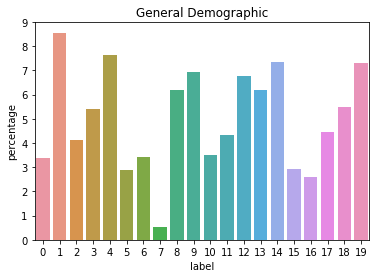

In [71]:
sns.barplot(x='label', y='percentage', data=gen_clusters_perc)
plt.title('General Demographic')
plt.show()

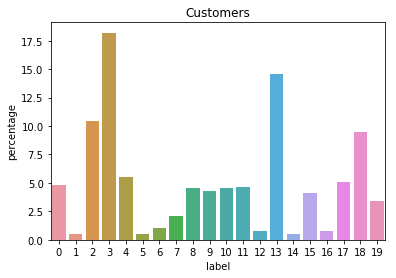

In [72]:
sns.barplot(x='label', y='percentage', data=cust_clusters_perc)
plt.title('Customers')
plt.show()

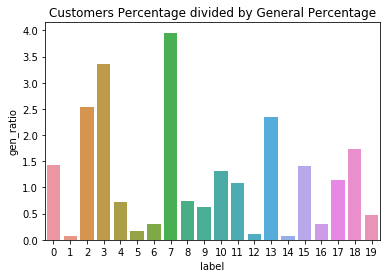

In [73]:
cust_clusters_perc['gen_ratio'] = cust_clusters_perc['percentage']/gen_clusters_perc['percentage']
sns.barplot(x='label', y='gen_ratio', data=cust_clusters_perc)
plt.title('Customers Percentage divided by General Percentage')
plt.show()

In [74]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
over_rep = cust_clusters_perc.sort_values(by='gen_ratio').iloc[-1].label
print('Over represented customers are in cluster: {:.0f}'
      .format(over_rep))

Over represented customers are in cluster: 7


In [75]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_rep = cust_clusters_perc.sort_values(by='gen_ratio').iloc[0].label
print('Under represented customers are in cluster: {:.0f}'
      .format(under_rep))

Under represented customers are in cluster: 1


In [76]:
def get_mean_diff(gen_df, cust_df, clustered, columns, label):
    """
    
    """
    clust_scaled = cust_df[clustered['label']==label]
    clust_scaled_mean = clust_scaled.mean(axis=0)
    mean_diff= pd.DataFrame(list(zip(columns, clust_scaled_mean - GEN_SCALED_MEAN)), 
                         columns= ['feature', 'mean_diff'])
    mean_diff = mean_diff.sort_values(by='mean_diff')
    mean_diff = mean_diff.sort_values(by='mean_diff', ascending=True)
    
    return mean_diff

In [77]:
def get_interesting_features(gen_df, cust_df, clustered, columns, nums, label, n_features):
    mean_diff = get_mean_diff(gen_df, cust_df, clustered, columns, label)
    num_feats = mean_diff.loc[mean_diff['feature'].isin(nums)].sort_values(by='mean_diff', ascending=True)
    num_feats = pd.concat([num_feats[:n_features], num_feats[-n_features:]])
    cat_feats = mean_diff.loc[~mean_diff['feature'].isin(nums)].sort_values(by='mean_diff', ascending=True)
    cat_feats = pd.concat([cat_feats[:n_features], cat_feats[-n_features:]])
    interesting_features = pd.concat([num_feats, cat_feats]).sort_values(by='mean_diff')
    
    return interesting_features

In [78]:
%%time
GEN_SCALED_MEAN = gen_scaled.mean(axis=0)
numerical_features = get_numeric_features(gen_cleaned, feats_appended)

CPU times: user 922 ms, sys: 2.28 s, total: 3.2 s
Wall time: 27.9 s


In [79]:
over_rep_features = get_interesting_features(gen_scaled, cust_scaled, cust_clusters, 
                                      columns=cust_cleaned.columns, 
                                      nums=numerical_features, label=over_rep, n_features=2)
over_rep_features

,feature,mean_diff
7,RETOURTYP_BK_S,-2.322904
36,ONLINE_AFFINITAET,-1.732554
266,LP_FAMILIE_GROB_1.0,-1.010738
65,LP_FAMILIE_FEIN_1.0,-1.010738
56,FINANZ_VORSORGER,0.785895
11,FINANZ_MINIMALIST,0.832815
114,CJT_GESAMTTYP_0.0,13.624583
149,GFK_URLAUBERTYP_0.0,13.624583


RETOURTYP_BK_S
Return type
- 0: unknown
- 1: influenceable Crazy-Shopper
- 2: demanding Heavy-Returner
- 3: incentive-receptive Normal-Returner
- 4: conservative Low-Returner
- 5: determined Minimal-Returner

ONLINE_AFFINITAET
Online affinity
- 0: none
- 1: low
- 2: middle
- 3: high
- 4: very high
- 5: highest

LP_FAMILIE_GROB
Family type, rough scale
- 0: unknown
- 1: single (maps to 1 in fine scale)
- 2: couple (maps to 2 in fine scale)
- 3: single parent (maps to 3-5 in fine scale)
- 4: family (maps to 6-8 in fine scale)
- 5: multiperson household (maps to 9-11 in fine scale)
    
LP_FAMILIE_FEIN
Family type, fine scale
-  0: unknown
-  1: single
-  2: couple
-  3: young single parent
-  4: single parent with teenager
-  5: single parent with child of full age
-  6: young family
-  7: family with teenager
-  8: family with child of full age
-  9: shared flat
- 10: two-generational household
- 11: multi-generational household
    
FINANZ_VORSORGER
- VORSORGER: be prepared

Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low
    
FINANZ_MINIMALIST
- MINIMALIST: low financial interest
Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

CJT_GESAMTTYP
Customer-Journey-Typology: preferred information and buying channels for
consumer
- 0: unknown
- 1: Advertising- and Consumptionminimalist
- 2: Advertising- and Consumptiontraditionalist
- 3: advertisinginterested Store-shopper
- 4: advertisinginterested Online-shopper
- 5: Advertising- and Cross-Channel-Enthusiast
- 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour
    
GFK_URLAUBERTYP
Vacation habits
-  1: Event travelers
-  2: Family-oriented vacationists
-  3: Winter sportspeople
-  4: Culture lovers
-  5: Nature fans
-  6: Hiker
-  7: Golden ager
-  8: Homeland-connected vacationists
-  9: Package tour travelers
- 10: Connoisseurs
- 11: Active families
- 12: Without vacation

In [80]:
under_rep_features = get_interesting_features(gen_scaled, cust_scaled, cust_clusters, 
                                      columns=cust_cleaned.columns, 
                                      nums=numerical_features, label=under_rep, n_features=2)
under_rep_features

,feature,mean_diff
11,FINANZ_MINIMALIST,-1.263171
44,SEMIO_VERT,-0.996784
271,ANREDE_KZ_1.0,-0.958480
59,PLZ8_BAUMAX_1.0,-0.772221
39,SEMIO_KAEM,1.132124
21,SEMIO_RAT,1.176626
259,FINANZTYP_1.0,1.227031
87,LP_LEBENSPHASE_GROB_1.0,1.469298


FINANZ_MINIMALIST, 
- MINIMALIST: low financial interest

Financial typology, for each dimension:
- -1: unknown
-  1: very high
-  2: high
-  3: average
-  4: low
-  5: very low

SEMIO_VERT
- VERT: dreamful
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

ANREDE_KZ
Gender
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: male
-  2: female

PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

SEMIO_KAEM
- KAEM: combative attitude
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

SEMIO_RAT
- RAT: rational
Personality typology, for each dimension:
- -1: unknown
-  1: highest affinity
-  2: very high affinity
-  3: high affinity
-  4: average affinity
-  5: low affinity
-  6: very low affinity
-  7: lowest affinity
-  9: unknown

FINANZTYP
Most descriptive financial type for individual
- -1: unknown
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)

LP_LEBENSPHASE_GROB
Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [81]:
notebook_toc = time.time()
print('It took {:.1f} minutes to run the whole notebook'.format((notebook_toc-notebook_tic)/60))

It took 7.8 minutes to run the whole notebook
